# compare the surrogate model using GPR and Random Forest

In [1]:
path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src'
sys.path.append(path_MOASMO)
import sampling
import gp
import NSGA2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pickle
from MOASMO_parameters import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def read_parameter_csv(file_parameter_list):
    df_calibparam = pd.read_csv(file_parameter_list)
    for c in ['Upper', 'Lower', 'Factor', 'Value']:
        if c in df_calibparam.columns:
            if isinstance(df_calibparam.iloc[0][c], str):
                arr = []
                for i in range(len(df_calibparam)):
                    vi = df_calibparam.iloc[i][c]
                    if ',' in vi:
                        arr.append(np.array(vi.split(',')).astype(np.float64))
                    elif '[' in vi:
                        arr.append(np.array(vi.strip('[]').replace('\n', '').split(), dtype=np.float64))
                    else:
                        try:
                            arr.append(np.array([np.float64(vi)]))
                        except:
                            arr.append(np.array([-99999]))
                df_calibparam[c] = arr
    return df_calibparam

In [2]:
# GPR functions
# cross validation of surrogate model using GPR
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

def calculate_rmse(y_true, y_pred):
    """Calculate the Root Mean Squared Error (RMSE) between true values and predicted values."""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse



In [8]:
rmse_all1 = np.nan * np.zeros([100, 2])
rmse_all2 = np.nan * np.zeros([100, 2])

alpha = 1e-3
lb = 1e-3
ub = 1e3
nu = 2.5

for b in range(100):
    print('Dealing basin', b)

    # input data: parameters and objective functions
    param_infofile = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/param_ASG_20221206_moasmo.csv'
    param_filelist = [f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO/level1_{b}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv']
    metric_filelist = [f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO/level1_{b}_MOASMOcalib/ctsm_outputs//iter0_all_metric.csv']


    # input data x (parameter sets) and output data y (objective function values)
    df_param = pd.concat(map(pd.read_csv, param_filelist))
    df_metric = pd.concat(map(pd.read_csv, metric_filelist))
    df_info = read_parameter_csv(param_infofile)

    param_names = df_info['Parameter'].values # exclude binded parameters
    df_param = df_param[param_names]

    xlb = np.array([np.nanmean(v) for v in df_info['Lower']])
    xub = np.array([np.nanmean(v) for v in df_info['Upper']])

    x = df_param.to_numpy()
    y = df_metric.to_numpy()

    nInput = x.shape[1]
    nOutput = y.shape[1]
    
    
    # build SM model
    kf = KFold(n_splits=5)
    kf.get_n_splits(x)
    
    
    for i, (train_index, test_index) in enumerate(kf.split(x)):
    
        scaler = StandardScaler()
        scaler.fit(x[train_index, :])

        x_train = scaler.transform(x[train_index, :])
        y_train = y[train_index, :]

        x_test= scaler.transform(x[test_index, :])
        y_test = y[test_index, :]


        # kernel = DotProduct() + WhiteKernel()
        # kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
        # smi = GaussianProcessRegressor(kernel=kernel)
        
        # # Sklearn GPR
        # kernel = Matern(length_scale=1.0, nu=1.5)
        # smi = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
        # smi.fit(x_train, y_train[:,0])
        # rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
        
        # MO-ASMO GPR
        sm_ma = gp.GPR_Matern(x_train, y_train, x_train.shape[0], nOutput, x_train.shape[0], xlb, xub, alpha=alpha, leng_sb=[lb,ub], nu=nu)
        rmse = calculate_rmse(y_test[:,0], sm_ma.predict(x_test)[:,0])
        
        rmse_all1[b, 0] = rmse

        smi = RandomForestRegressor()
        smi.fit(x_train, y_train[:,0])
        rmse = calculate_rmse(y_test[:,0], smi.predict(x_test))
        rmse_all1[b, 1] = rmse
        
        # # Sklearn GPR
        # kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
        # smi = GaussianProcessRegressor(kernel=kernel, )
        # smi.fit(x_train, y_train[:,1])
        # rmse = calculate_rmse(y_test[:,1], smi.predict(x_test))
        
        # MO-ASMO GPR
        rmse = calculate_rmse(y_test[:,1], sm_ma.predict(x_test)[:,1])
        
        rmse_all2[b, 0] = rmse

        smi = RandomForestRegressor()
        smi.fit(x_train, y_train[:,1])
        rmse = calculate_rmse(y_test[:,1], smi.predict(x_test))
        rmse_all2[b, 1] = rmse
    

Dealing basin 0
Dealing basin 1
Dealing basin 2
Dealing basin 3
Dealing basin 4
Dealing basin 5
Dealing basin 6
Dealing basin 7
Dealing basin 8
Dealing basin 9
Dealing basin 10
Dealing basin 11
Dealing basin 12
Dealing basin 13
Dealing basin 14
Dealing basin 15
Dealing basin 16
Dealing basin 17
Dealing basin 18
Dealing basin 19
Dealing basin 20
Dealing basin 21
Dealing basin 22
Dealing basin 23
Dealing basin 24
Dealing basin 25
Dealing basin 26
Dealing basin 27
Dealing basin 28
Dealing basin 29
Dealing basin 30
Dealing basin 31
Dealing basin 32
Dealing basin 33
Dealing basin 34
Dealing basin 35
Dealing basin 36
Dealing basin 37
Dealing basin 38
Dealing basin 39
Dealing basin 40
Dealing basin 41
Dealing basin 42
Dealing basin 43
Dealing basin 44
Dealing basin 45
Dealing basin 46
Dealing basin 47
Dealing basin 48
Dealing basin 49
Dealing basin 50
Dealing basin 51
Dealing basin 52
Dealing basin 53
Dealing basin 54
Dealing basin 55
Dealing basin 56


FileNotFoundError: [Errno 2] No such file or directory: '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO/level1_56_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv'

In [ ]:
# MO-ASMO GPR
sm_ma = gp.GPR_Matern(x, y, x.shape[0], nOutput, x.shape[0], xlb, xub, alpha=alpha, leng_sb=[lb,ub], nu=nu)
sm_ma.predict(x)/y

GPR, RF 5-fold CV metric-1 RMSE: [0.90565523 0.09849399]
GPR, RF 5-fold CV metric-2 RMSE: [8.51863974 1.14519557]


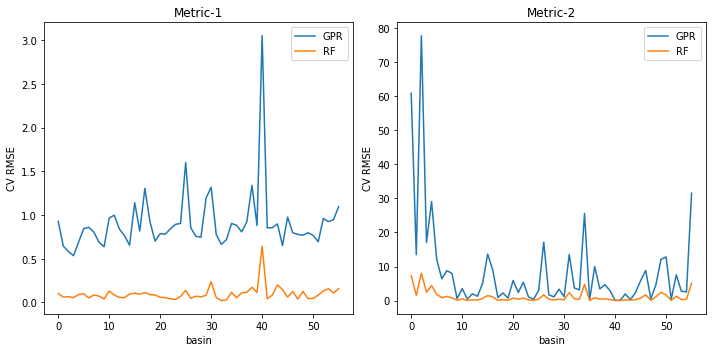

In [9]:
print('GPR, RF 5-fold CV metric-1 RMSE:', np.nanmean(rmse_all1, axis=0))
print('GPR, RF 5-fold CV metric-2 RMSE:', np.nanmean(rmse_all2, axis=0))

fig, axs = plt.subplots(1, 2, figsize=[10, 5])

ax = axs[0]
ax.plot(rmse_all1)
ax.set_xlabel('basin')
ax.set_ylabel('CV RMSE')
ax.set_title('Metric-1')
ax.legend(['GPR','RF'])

ax = axs[1]
ax.plot(rmse_all2)
ax.set_xlabel('basin')
ax.set_ylabel('CV RMSE')
ax.set_title('Metric-2')
ax.legend(['GPR','RF'])

plt.tight_layout()
plt.show()